<a href="https://www.kaggle.com/code/yorkyong/obesity-risk-xgb-rf-cb-ensemble?scriptVersionId=163097462" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

### <b><span style='color:#FFCE30'> 1.1 |</span> Log</b>
- V1: XGBoost baseline only
- V2: XGBoost with Optuna Hyperparameter Tuning
- V3: Add BMI feature with binning
- V9: Add Random Forest with Hyperparameter Tuning + Ensemble
- v10: Add CatBoost into Ensemble

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>2 |</span></b> <b>LOAD LIBRARY & DATA</b></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Set the display options to show all columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
#Load the data
train = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
submit = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")

In [3]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>ASSEMBLE PIPELINE</b></div>

In [6]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

In [7]:
#applies transformers to different columns.
multicolumn_prep = ColumnTransformer([ ('encode', 
                                       OneHotEncoder(handle_unknown='ignore'), 
                                       ['Gender', 'family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']),
                                     ],
                                     remainder='passthrough')
multicolumn_prep

ColumnTransformer(remainder='passthrough',
                  transformers=[('encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC',
                                  'MTRANS'])])

In [8]:
class MinMaxScalerForNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        # Select numeric columns
        self.numeric_cols = X.select_dtypes(include=['number']).columns
        # Fit the scaler on the numeric data
        self.scaler.fit(X[self.numeric_cols], y)
        return self

    def transform(self, X, y=None):
        # Transform only the numeric columns and leave others unchanged
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler.transform(X[self.numeric_cols])
        return X_copy

In [9]:
# Using Standard Scaler or Robust Scaler to scale numeric variables

class StandardScalerNamed(StandardScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)
    
    
class RobustScalerNamed(RobustScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)

### <b><span style='color:#FFCE30'> 3A.1 |</span> Body Mass Index</b>
- BMI (Body Mass Index): BMI is a common feature used to assess obesity
- Calculate BMI using the formula: BMI = Weight (kg) / (Height (m) * Height (m))

In [10]:
# Calculate BMI (Weight (kg) / (Height (m) * Height (m))) and add it as a new column
train['BMI'] = train['Weight'] / (train['Height'] ** 2)
test['BMI'] = test['Weight'] / (test['Height'] ** 2)

train

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
class BMIBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['BMI_Category'] = pd.cut(X_copy['BMI'],
                                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'],
                                        right=False)
        return X_copy
    
BMIBinner().fit_transform(train)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,BMI_Category
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,Overweight
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,Normal
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,Underweight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,Obesity III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,Overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084,Obesity II
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278,Underweight
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841,Obesity I
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693,Overweight


### <b><span style='color:#FFCE30'> 3A.2 |</span> Columns_Dropper</b>

In [13]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

DropColumn(cols=['MTRANS']).fit_transform(train)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,BMI
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Overweight_Level_II,28.259565
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Normal_Weight,23.422091
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Insufficient_Weight,17.126706
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Obesity_Type_III,44.855798
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Obesity_Type_II,36.587084
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Insufficient_Weight,17.099278
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Obesity_Type_II,31.889841
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Overweight_Level_II,28.899693


### <b><span style='color:#FFCE30'> 3A.3 |</span> Log Transform</b>

In [14]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """Custom transformer to apply log transformation to numerical columns."""
    
    def __init__(self, cols=None):
        self.cols = cols  # List of numerical columns to transform
    
    def fit(self, X, y=None):
        return self  # Nothing to do in the fit method
    
    def transform(self, X):
        X_transformed = X.copy()
        if self.cols is None:
            # If cols is None, apply log transformation to all numerical columns
            numerical_cols = X.select_dtypes(include=np.number).columns
            X_transformed[numerical_cols] = np.log1p(X_transformed[numerical_cols])
        else:
            # Apply log transformation to specified columns
            for col in self.cols:
                X_transformed[col] = np.log1p(X_transformed[col])
        return X_transformed
    
LogTransformer(cols=['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE','BMI']).fit_transform(train)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,3.236441,0.993251,4.414856,yes,yes,1.098612,1.382110,Sometimes,no,1.325369,no,0.000000,0.681314,Sometimes,Public_Transportation,Overweight_Level_II,3.376207
1,1,Female,2.944439,0.940007,4.060443,yes,yes,1.098612,1.386294,Frequently,no,1.098612,no,0.693147,0.693147,no,Automobile,Normal_Weight,3.195488
2,2,Female,2.944439,0.997487,3.935070,yes,yes,1.057976,0.880326,Sometimes,no,1.068283,no,0.623821,0.983420,no,Public_Transportation,Insufficient_Weight,2.897386
3,3,Female,3.088892,0.997218,4.884882,yes,yes,1.386294,1.386294,Sometimes,no,0.983598,no,0.903353,0.576725,Sometimes,Public_Transportation,Obesity_Type_III,3.825502
4,4,Male,3.485572,1.069591,4.551749,yes,yes,1.302821,1.089057,Sometimes,no,1.091872,no,1.087879,0.658411,Sometimes,Public_Transportation,Overweight_Level_II,3.280879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,3.263355,1.017629,4.746558,yes,yes,1.365986,1.386294,Sometimes,no,1.147977,no,0.846091,0.179551,Sometimes,Public_Transportation,Obesity_Type_II,3.626660
20754,20754,Male,2.944439,0.996949,3.931826,no,yes,1.386294,1.609438,Frequently,no,0.693147,no,1.098612,0.693147,Sometimes,Public_Transportation,Insufficient_Weight,2.895872
20755,20755,Male,3.049322,1.036580,4.668900,yes,yes,1.226072,1.386294,Sometimes,no,1.098612,no,0.769200,0.787748,no,Public_Transportation,Obesity_Type_II,3.493164
20756,20756,Male,3.551138,0.993252,4.436990,yes,yes,1.300529,1.089057,Sometimes,no,1.145762,no,0.000000,0.679978,no,Automobile,Overweight_Level_II,3.397848


### <b><span style='color:#FFCE30'> 3A.4 |</span> Scaling</b>

In [15]:
named_preprocessing_pipeline = Pipeline([
    ('BMI_binning', BMIBinner()),
    ('drop', DropColumn(cols=['id'])),
    ('log_transform', LogTransformer(cols=['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE','BMI'])),
    ('prep',ColumnTransformer([ ('encode', 
                                 OneHotEncoder(handle_unknown='ignore',sparse_output=False), 
                                 ['Gender', 'family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS','BMI_Category']),
                              ],
                              remainder='passthrough').set_output(transform='pandas')),
])

named_preprocessing_pipeline      

Pipeline(steps=[('BMI_binning', BMIBinner()), ('drop', DropColumn(cols=['id'])),
                ('log_transform',
                 LogTransformer(cols=['Age', 'Height', 'Weight', 'FCVC', 'NCP',
                                      'CH2O', 'FAF', 'TUE', 'BMI'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC', 'MTRANS',
                                                   'BMI_Category'])]))])

In [16]:
modelling_pipeline = Pipeline(named_preprocessing_pipeline.steps + [('scale',RobustScaler().set_output(transform='pandas')),])
modelling_pipeline

Pipeline(steps=[('BMI_binning', BMIBinner()), ('drop', DropColumn(cols=['id'])),
                ('log_transform',
                 LogTransformer(cols=['Age', 'Height', 'Weight', 'FCVC', 'NCP',
                                      'CH2O', 'FAF', 'TUE', 'BMI'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC', 'MTRANS',
                                                   'BMI_Category'])])),
                ('scale', RobustScaler())])

In [17]:
#checking output on X_train df
df_train = modelling_pipeline.fit_transform(train.drop(['NObeyesdad'], axis=1))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 37 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   encode__Gender_Female                       20758 non-null  float64
 1   encode__Gender_Male                         20758 non-null  float64
 2   encode__family_history_with_overweight_no   20758 non-null  float64
 3   encode__family_history_with_overweight_yes  20758 non-null  float64
 4   encode__FAVC_no                             20758 non-null  float64
 5   encode__FAVC_yes                            20758 non-null  float64
 6   encode__CAEC_Always                         20758 non-null  float64
 7   encode__CAEC_Frequently                     20758 non-null  float64
 8   encode__CAEC_Sometimes                      20758 non-null  float64
 9   encode__CAEC_no                             20758 non-null  float64
 10  encode__SM

In [18]:
#checking output on X_test df
df_test = pd.DataFrame(modelling_pipeline.transform(test))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 37 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   encode__Gender_Female                       13840 non-null  float64
 1   encode__Gender_Male                         13840 non-null  float64
 2   encode__family_history_with_overweight_no   13840 non-null  float64
 3   encode__family_history_with_overweight_yes  13840 non-null  float64
 4   encode__FAVC_no                             13840 non-null  float64
 5   encode__FAVC_yes                            13840 non-null  float64
 6   encode__CAEC_Always                         13840 non-null  float64
 7   encode__CAEC_Frequently                     13840 non-null  float64
 8   encode__CAEC_Sometimes                      13840 non-null  float64
 9   encode__CAEC_no                             13840 non-null  float64
 10  encode__SM

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>4 |</span></b> <b>MODELLING</b></div>

In [19]:
#XGBoost best parameters 
xgb_params_optuna =  {'max_depth': 5, 
                      'min_child_weight': 5, 
                      'learning_rate': 0.1026000975245331, 
                      'n_estimators': 294, 
                      'subsample': 0.6632961735519581, 
                      'colsample_bytree': 0.525660773797631, 
                      'random_state': 2024}

In [20]:
from xgboost import XGBClassifier

# Create a XGBClassifier
XGB_classifier = XGBClassifier(**xgb_params_optuna)

XGB_pipeline = make_pipeline(modelling_pipeline, XGB_classifier)
XGB_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('BMI_binning', BMIBinner()),
                                 ('drop', DropColumn(cols=['id'])),
                                 ('log_transform',
                                  LogTransformer(cols=['Age', 'Height',
                                                       'Weight', 'FCVC', 'NCP',
                                                       'CH2O', 'FAF', 'TUE',
                                                       'BMI'])),
                                 ('prep',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Gender'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.1026000975245331, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=294, n_jobs=None,
                               num_parallel_tree=None, random_state=2024, ...))])

In [21]:
rf_params_optuna = {'n_estimators': 934, 
                    'max_depth': 15, 
                    'min_samples_split': 3, 
                    'min_samples_leaf': 1, 
                    'max_features': 'sqrt'}

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier
RF_classifier = RandomForestClassifier(**rf_params_optuna)

# Create a pipeline with preprocessing and the RandomForestClassifier
RF_pipeline = make_pipeline(modelling_pipeline, RF_classifier)

# Return the RandomForest pipeline
RF_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('BMI_binning', BMIBinner()),
                                 ('drop', DropColumn(cols=['id'])),
                                 ('log_transform',
                                  LogTransformer(cols=['Age', 'Height',
                                                       'Weight', 'FCVC', 'NCP',
                                                       'CH2O', 'FAF', 'TUE',
                                                       'BMI'])),
                                 ('prep',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Gender',
                                                                    'family_history_with_overweight',
                                                                    'FAVC',
                                                                    'CAEC',
                                                                    'SMOKE',
                                                                    'SCC',
                                                                    'CALC',
                                                                    'MTRANS',
                                                                    'BMI_Category'])])),
                                 ('scale', RobustScaler())])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, min_samples_split=3,
                                        n_estimators=934))])

In [23]:
catboost_params_optuna = {
    'iterations': 683, 
    'depth': 10, 
    'min_data_in_leaf': 4, 
    'learning_rate': 0.07773777373253303,
}

In [24]:
#catboost library
from catboost import CatBoostClassifier

# catboost model
cb_model = CatBoostClassifier(**catboost_params_optuna, random_state = 2024, verbose=0)


cb_pipeline = make_pipeline(modelling_pipeline, cb_model)
cb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('BMI_binning', BMIBinner()),
                                 ('drop', DropColumn(cols=['id'])),
                                 ('log_transform',
                                  LogTransformer(cols=['Age', 'Height',
                                                       'Weight', 'FCVC', 'NCP',
                                                       'CH2O', 'FAF', 'TUE',
                                                       'BMI'])),
                                 ('prep',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Gender',
                                                                    'family_history_with_overweight',
                                                                    'FAVC',
                                                                    'CAEC',
                                                                    'SMOKE',
                                                                    'SCC',
                                                                    'CALC',
                                                                    'MTRANS',
                                                                    'BMI_Category'])])),
                                 ('scale', RobustScaler())])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7eed9c35a500>)])

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>EVALUATION</b></div>

In [25]:
trainX = train.drop(['NObeyesdad'], axis=1) 
trainy = train['NObeyesdad']

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
trainy_encoded = label_encoder.fit_transform(trainy)

trainy_encoded

array([6, 1, 0, ..., 3, 6, 3])

In [27]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score

# # Number of folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Cross-validation results
# cv_results = []

# # Stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(trainX, trainy_encoded)):
#     X_train_fold, X_val_fold = trainX.iloc[train_idx], trainX.iloc[val_idx]
#     y_train_fold, y_val_fold = trainy_encoded[train_idx], trainy_encoded[val_idx]

#     # Create and fit the XGBoostClassifier on the training fold
#     XGB_pipeline.fit(X_train_fold, y_train_fold)

#     # Predictions on the validation fold
#     y_pred = XGB_pipeline.predict(X_val_fold)

#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val_fold, y_pred)

#     # Print and store the results
#     print(f'Fold {fold + 1}, Accuracy Score on Validation Set: {accuracy}')
#     print('-' * 70)

#     cv_results.append(accuracy)

# # Average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage Accuracy Score across {n_splits} folds: {average_cv_result}')


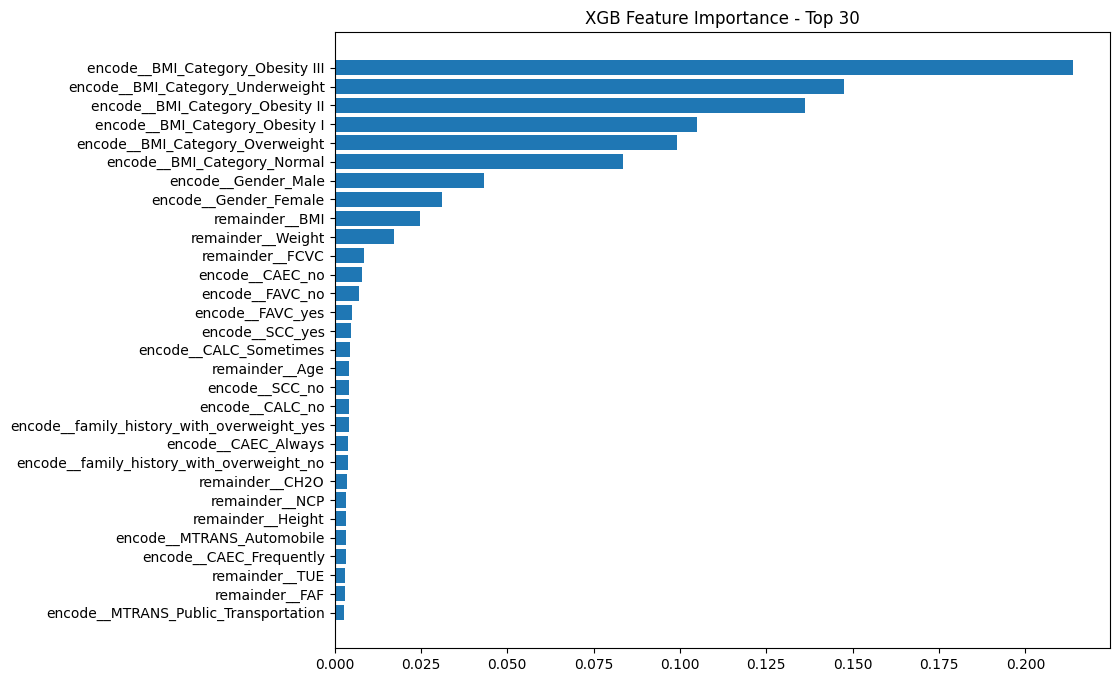

In [28]:
XGB_pipeline.fit(trainX, trainy_encoded)

TOP = 30

feature_importance = XGB_classifier.feature_importances_

# Get the feature names from 'train'
feature_names = df_train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'XGB Feature Importance - Top {TOP}')
plt.show()

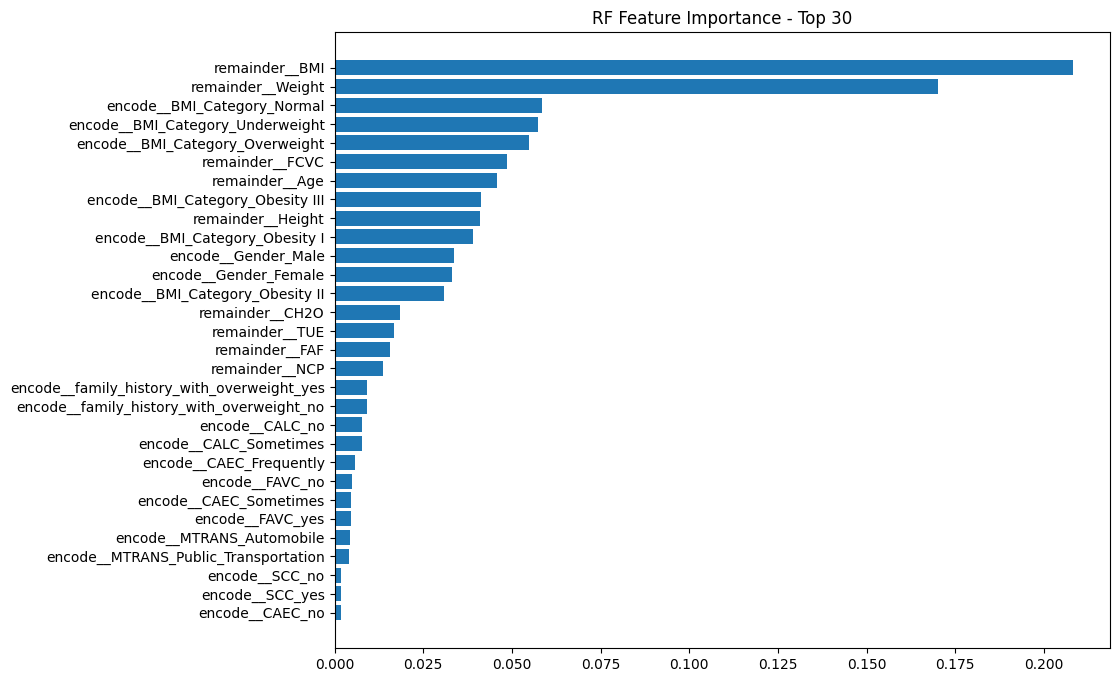

In [29]:
RF_pipeline.fit(trainX, trainy_encoded)

TOP = 30

feature_importance = RF_classifier.feature_importances_

# Get the feature names from 'train'
feature_names = df_train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'RF Feature Importance - Top {TOP}')
plt.show()

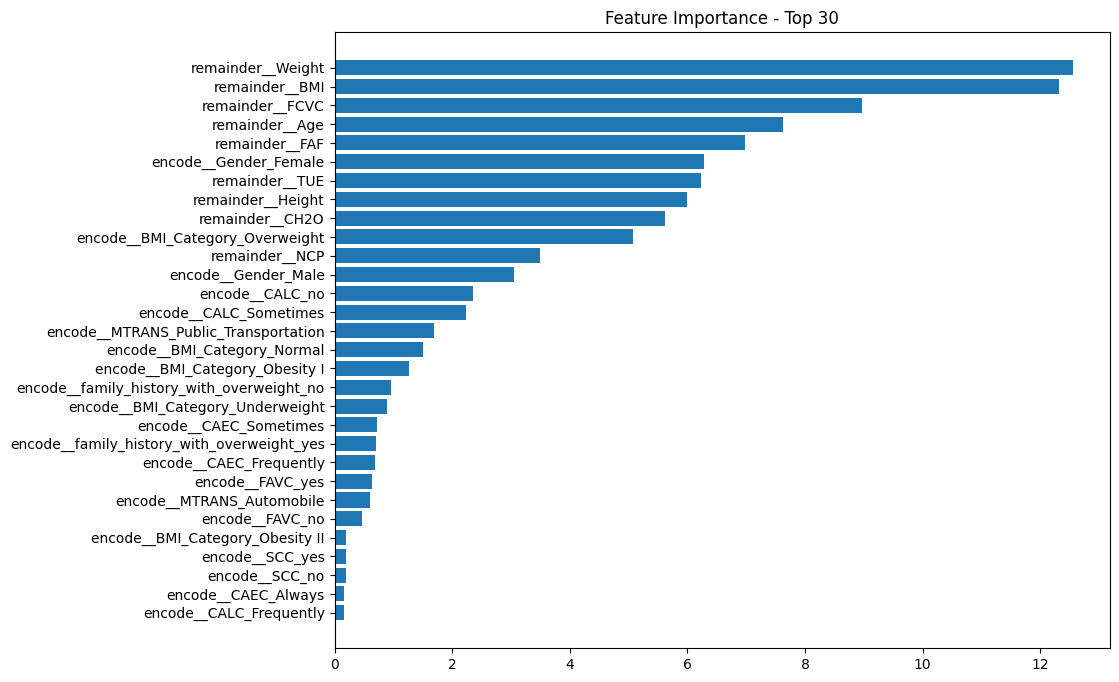

In [30]:
cb_pipeline.fit(trainX, trainy_encoded)

TOP = 30

feature_importance = cb_model.feature_importances_

# Get the feature names from 'train'
feature_names = df_train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>TUNING WITH OPTUNA</b></div>

In [31]:
# import optuna
# import xgboost as xgb
# from sklearn.model_selection import  cross_val_score
# from sklearn.model_selection import StratifiedKFold

# def objective_xgb(trial):
#     """Define the objective function for XGBClassifier"""

#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'random_state': trial.suggest_categorical('random_state', [42]),
#         'tree_method': 'hist',  # Use GPU for training
#         'device' : 'cuda',
#         'eval_metric': 'auc',  # Evaluation metric
#         'verbosity': 2,  # Set verbosity to 0 for less output
#     }

#     xgb_model = xgb.XGBClassifier(**params)
#     xgb_pipeline = make_pipeline(modelling_pipeline, xgb_model)

#     cv = abs(cross_val_score(xgb_pipeline, trainX, trainy_encoded, cv=skf, scoring='accuracy').mean())

#     return cv

# # Define a pruning callback for Optuna
# def pruning_callback(study, trial):
#     if study.best_trial.number != trial.number:
#         # Prune if the trial is not the current best
#         if study.trials[trial.number].intermediate_values:
#             last_value = max(study.trials[trial.number].intermediate_values.values())
#             if last_value < study.best_value:
#                 raise optuna.TrialPruned()
            
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1989)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=10, callbacks=[pruning_callback])

# # Get the best parameters
# best_params_xgb = study.best_params
# print("Best Hyperparameters for XGBoost:", best_params_xgb)

- Best Hyperparameters for XGBoost: {'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.1026000975245331, 'n_estimators': 294, 'subsample': 0.6632961735519581, 'colsample_bytree': 0.525660773797631, 'random_state': 2024}
- Best is trial 26 with value: 0.91049269912018.

In [32]:
# import optuna
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline

# # Define the objective function for RandomForestClassifier
# def objective_rf(trial):
#     rf_params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
#         'random_state': 42
#     }

#     # Create RandomForestClassifier with suggested parameters
#     rf_classifier = RandomForestClassifier(**rf_params)

#     # Create pipeline with preprocessing steps and RandomForestClassifier
#     rf_pipeline = make_pipeline(modelling_pipeline, rf_classifier)

#     # Compute cross-validation score using accuracy as the scoring metric
#     cv = cross_val_score(rf_pipeline, trainX, trainy_encoded, cv=skf, scoring='accuracy').mean()

#     return cv

# # Define a pruning callback for Optuna
# def pruning_callback(study, trial):
#     if study.best_trial.number != trial.number:
#         # Prune if the trial is not the current best
#         if study.trials[trial.number].intermediate_values:
#             last_value = max(study.trials[trial.number].intermediate_values.values())
#             if last_value < study.best_value:
#                 raise optuna.TrialPruned()

# # Define the StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1989)

# # Create an Optuna study for maximization
# study = optuna.create_study(direction='maximize')

# # Optimize the objective function with Optuna
# study.optimize(objective_rf, n_trials=10, callbacks=[pruning_callback])

# # Get the best parameters
# best_params_rf = study.best_params
# print("Best Hyperparameters for RandomForest:", best_params_rf)


- Trial 25 finished with value: 0.8962809619982822 and parameters: {'n_estimators': 934, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
- Best is trial 25 with value: 0.8962809619982822.

In [33]:
# from sklearn.model_selection import StratifiedKFold
# import optuna
# from sklearn.model_selection import cross_val_score

# # Suppress FutureWarnings related to is_sparse
# warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1989)

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 5, 15),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
#         'task_type': 'GPU',
#     }
    
#     cb_model = CatBoostClassifier(**params, random_state=42, grow_policy='Lossguide', verbose=0)
#     cb_pipeline = make_pipeline(modelling_pipeline, cb_model)

#     # Using cross_val_score with 'cv' parameter and scoring='accuracy'
#     cv = cross_val_score(cb_pipeline, trainX, trainy, cv=skf, scoring='accuracy', n_jobs=-1).mean()

#     return cv

# # Create an Optuna study with pruning
# study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

# # Perform the optimization with more trials
# study.optimize(objective, n_trials=10)

# # Get the best hyperparameters
# best_params_cb = study.best_params
# print("Best Hyperparameters for CatBoost:", best_params_cb)

### <b><span style='color:#FFCE30'> 6.1C |</span> Best CatBoost Hyperparameter n=10 | random_state=1989 </b>
- 

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>SUBMISSION</b></div>

In [34]:
from sklearn.ensemble import VotingClassifier

In [35]:
ensemble_model = VotingClassifier(estimators=[
    ('xgb', XGB_pipeline),
    ('rf', RF_pipeline),
    ('cb', cb_pipeline),
        
]
                                  , voting='soft',
                                  weights = [0.6,0,0.4])

ensemble_model

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('BMI_binning',
                                                                BMIBinner()),
                                                               ('drop',
                                                                DropColumn(cols=['id'])),
                                                               ('log_transform',
                                                                LogTransformer(cols=['Age',
                                                                                     'Height',
                                                                                     'Weight',
                                                                                     'FCVC',
                                                                                     'NCP',
                                                                                     'CH2O',
                                                                                     'FAF',
                                                                                     'TUE',
                                                                                     'BMI'])),
                                                               ('prep',
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('encode',
                                                                                                 OneHotEncoder(handle_unknown='ig...
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('encode',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False),
                                                                                                 ['Gender',
                                                                                                  'family_history_with_overweight',
                                                                                                  'FAVC',
                                                                                                  'CAEC',
                                                                                                  'SMOKE',
                                                                                                  'SCC',
                                                                                                  'CALC',
                                                                                                  'MTRANS',
                                                                                                  'BMI_Category'])])),
                                                               ('scale',
                                                                RobustScaler())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7eed9c35a500>)]))],
                 voting='soft', weights=[0.6, 0, 0.4])

In [36]:
ensemble_model.fit(trainX, trainy_encoded)

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('BMI_binning',
                                                                BMIBinner()),
                                                               ('drop',
                                                                DropColumn(cols=['id'])),
                                                               ('log_transform',
                                                                LogTransformer(cols=['Age',
                                                                                     'Height',
                                                                                     'Weight',
                                                                                     'FCVC',
                                                                                     'NCP',
                                                                                     'CH2O',
                                                                                     'FAF',
                                                                                     'TUE',
                                                                                     'BMI'])),
                                                               ('prep',
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('encode',
                                                                                                 OneHotEncoder(handle_unknown='ig...
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('encode',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False),
                                                                                                 ['Gender',
                                                                                                  'family_history_with_overweight',
                                                                                                  'FAVC',
                                                                                                  'CAEC',
                                                                                                  'SMOKE',
                                                                                                  'SCC',
                                                                                                  'CALC',
                                                                                                  'MTRANS',
                                                                                                  'BMI_Category'])])),
                                                               ('scale',
                                                                RobustScaler())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7eed9c35a500>)]))],
                 voting='soft', weights=[0.6, 0, 0.4])

In [37]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score

# # Number of folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Cross-validation results
# cv_results = []

# # Stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(trainX, trainy_encoded)):
#     X_train_fold, X_val_fold = trainX.iloc[train_idx], trainX.iloc[val_idx]
#     y_train_fold, y_val_fold = trainy_encoded[train_idx], trainy_encoded[val_idx]

#     # Create and fit the XGBoostClassifier on the training fold
#     ensemble_model.fit(X_train_fold, y_train_fold)

#     # Predictions on the validation fold
#     y_pred = ensemble_model.predict(X_val_fold)

#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val_fold, y_pred)

#     # Print and store the results
#     print(f'Fold {fold + 1}, Accuracy Score on Validation Set: {accuracy}')
#     print('-' * 70)

#     cv_results.append(accuracy)

# # Average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage Accuracy Score across {n_splits} folds: {average_cv_result}')

In [38]:
predictions = ensemble_model.predict(test)

# Convert the label-encoded predictions back to their original labels
original_predictions = label_encoder.inverse_transform(predictions)

In [39]:
# Reset the index of the test dataframe
test_reset_index = test.reset_index()

# create Submission DataFrame
submission_df = pd.DataFrame({'id': test_reset_index['id'], 'NObeyesdad': original_predictions})

# save to CSV
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

In [40]:
submission_df

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


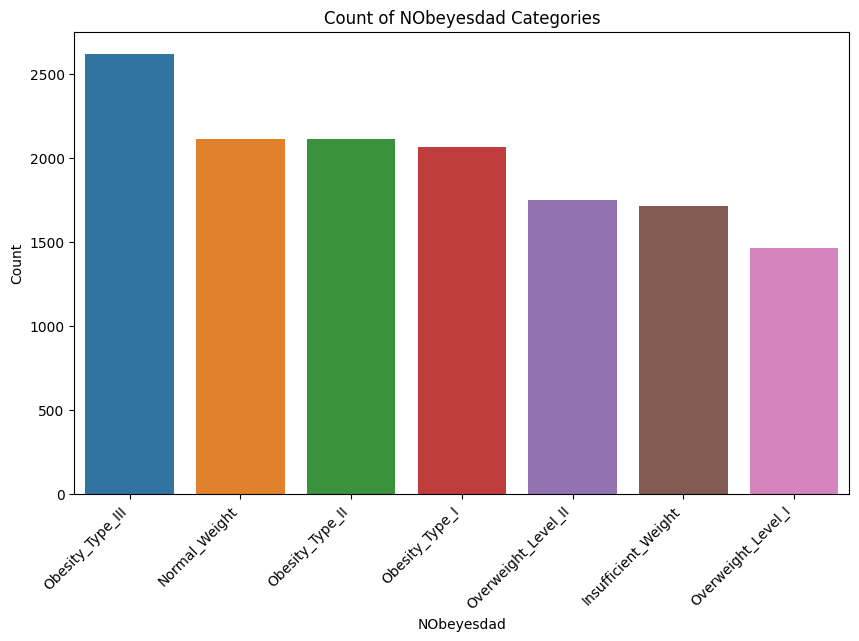

In [41]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=submission_df, x='NObeyesdad', order=submission_df['NObeyesdad'].value_counts().index)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.xlabel('NObeyesdad')
plt.ylabel('Count')
plt.title('Count of NObeyesdad Categories')
plt.show()